In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import time
from sklearn.preprocessing import MinMaxScaler



import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vus.utils.slidingWindows import find_length
from vus.utils.metrics import metricor

from vus.models.distance import Fourier
from vus.models.feature import Window
from vus.models.cnn import cnn
from vus.models.AE_mlp2 import AE_MLP2
from vus.models.lstm import lstm
from vus.models.ocsvm import OCSVM
from vus.models.poly import POLY
from vus.models.pca import PCA
from vus.models.norma import NORMA
from vus.models.matrix_profile import MatrixProfile
from vus.models.lof import LOF
from vus.models.iforest import IForest

from vus.analysis.score_computation import generate_data,compute_score
from vus.analysis.robustness_eval import compute_anomaly_acc_lag,compute_anomaly_acc_percentage,compute_anomaly_acc_noise,normalize_dict_exp,group_dict,box_plot,generate_curve


/opt/anaconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


# Training anomaly detection model

In this example, we train 9 different model on 4 possible datasets (we chooser by default the MBA(805) dataset, which is a dataset with easy to detect anomalies). For this statistical analysis, we choose in purpose the 10,000 first points. 

In [2]:
import os
all_files = [] 
for file in os.listdir('../../data'):
    all_files.append('../../data/{}'.format(file))

## Training all methods and computing the anomaly score

In [3]:
import json
import pickle

methods = [
    'NormA',
    'POLY',
    'IForest',
    'AE',
    'OCSVM',
    'MatrixProfile',
    'LOF',
    'LSTM',
    'CNN',
]

max_length = 10000
filepath = '../../data/MBA_ECG805_data.out'

pos_first_anom,slidingWindow,data,X_data,data_train,data_test,X_train,X_test,label = generate_data(filepath,0,max_length)
methods_scores =  compute_score(methods,slidingWindow,data,X_data,data_train,data_test,X_train,X_test)

## Visualization of the anomaly scores

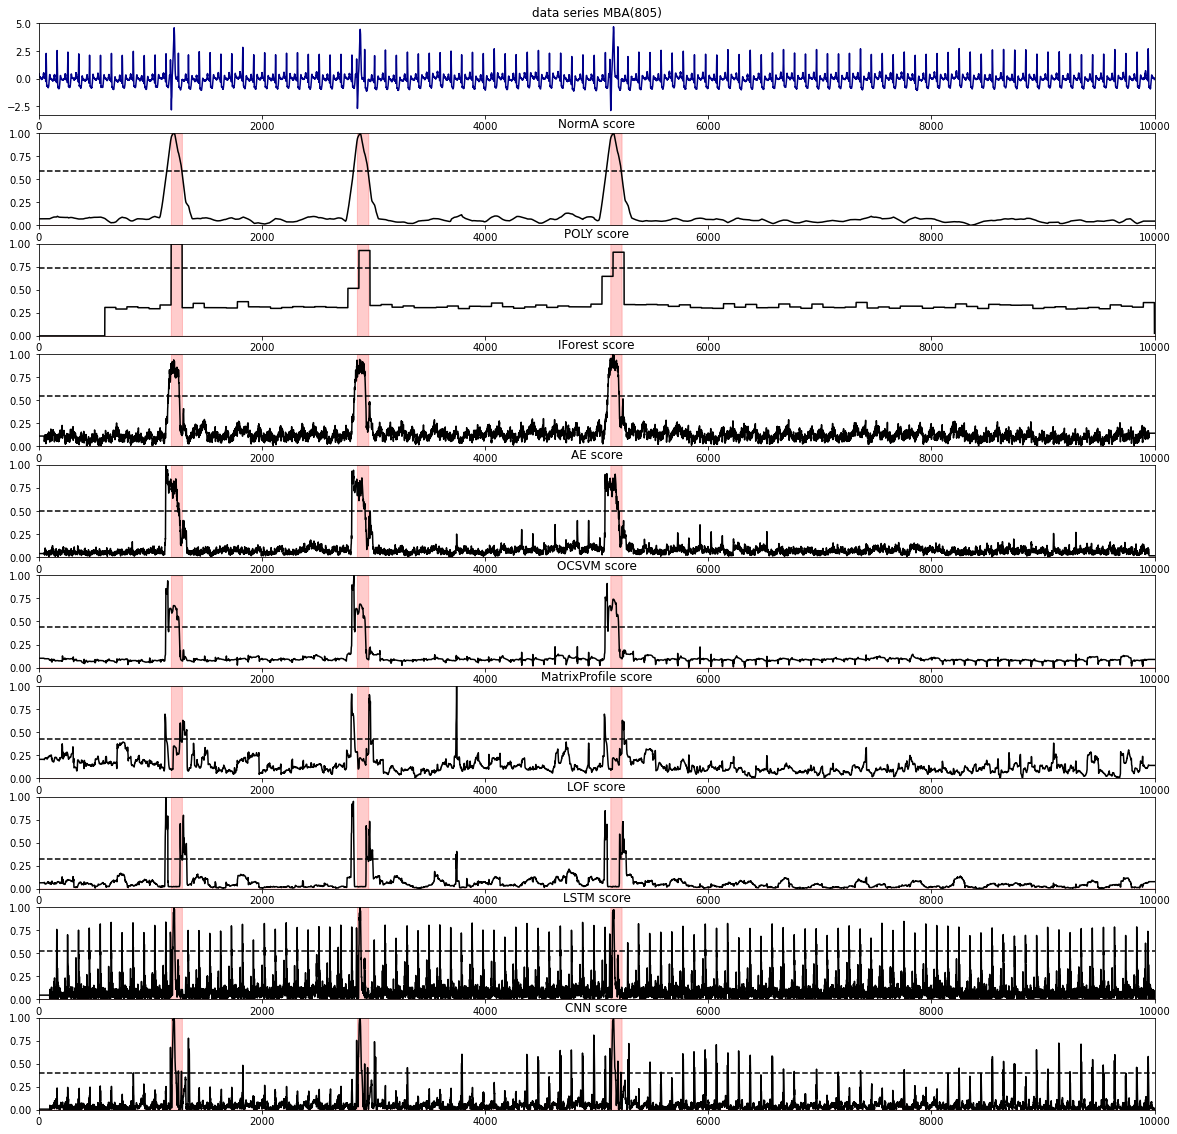

In [4]:
plt.figure(figsize=(20,20))
plt.subplot(10,1,1)
plt.plot(data,color='darkblue')
plt.xlim(0,len(data))
plt.title('data series MBA(805)')
for i,method in enumerate(methods):
    plt.subplot(10,1,2+i)
    plt.plot(methods_scores[method],color='black')
    plt.fill_between(list(range(len(methods_scores[method]))),[0]*len(methods_scores[method]),label,alpha=0.2,color='red')
    plt.title("{} score".format(method))
    plt.xlim(0,len(methods_scores[method]))
    plt.ylim(0,1)
    plt.hlines(np.mean(methods_scores[method])+3*np.std(methods_scores[method]), 0,len(label),linestyle='--')



# Statistical analysis

## Robustness to Lag

We first measure the accuracy variation (with 13 different accuracy measures) when we slide the label in an interval equal to half of the subsequence anomaly length (+- one-quarter of the subsequence length). With such slight variations, one can consider that the anomaly detection methods still detected the correct anomalies. Therefore, small variability in the accuracy measure demonstrates the robustness of the same accuracy measure to lag.

## Robustness to noise

We then measure the accuracy variation (with 13 different accuracy measures) when we inject random noise (at max 10% of the anomaly score amplitude) in the anomaly score. With such minor variations, one can consider that the anomaly detection methods still detected the correct anomalies. Therefore, small variability in the accuracy measure demonstrates the robustness of the same accuracy measure to noise.


## Robustness to normal/abnormal ratio

We then measure the accuracy variation (with 13 different accuracy measures) when we vary the normal/abnormal ratio of positive and negative labels (without changing the original data series). To do that, we find an anomaly's position and select an initial snippet of 500 points around this anomaly. Thus, the normal-abnormal ratio is high. We then increase the snippet until reaching 10,000 points. Thus, the normal-abnormal ratio is reducing. Note that when increasing the snippet, we might include new anomalies. However, the overall ratio is reducing, and most importantly, changing. As we are interested in varying the ratio, the latter framework is sufficient (see figure below).

## Separability

We then compare the accuracy values (for 13 different accuracy measures) when applying them to accurate and inaccurate anomaly detection methods. This choice is made visually from the previous plot. We also randomly inject lag and noise into the corresponding anomaly score and compute the detection accuracy 30 times.

For each accuracy measure, we thus obtain two sets of accuracy values $X_a$ and $X_b$ for both accurate and inaccurate methods, respectively. Finally, we use the Z-test to evaluate the differences between $X_a$ and $X_b$ distributions:

$$
z\text{-}test = \frac{\mu(X_a) - \mu(X_i)}{\sqrt{\sigma(X_a)^2 + \sigma(X_i)^2}}
$$



(0.0, 0.3)

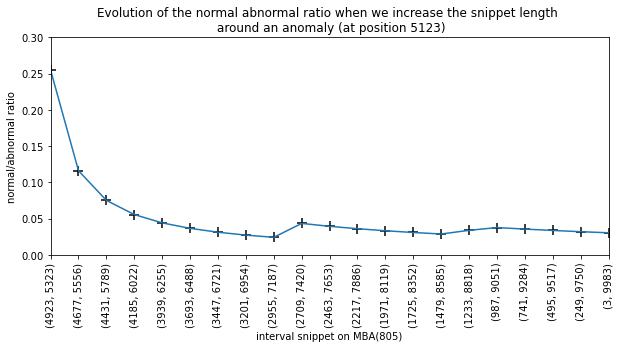

In [5]:
def test_snippet_ratio(label,slidingWindow,pos_first_anom):
    list_pos = []
    result = []
    step_a = max(0,(len(label) - pos_first_anom-200))//20
    step_b = max(0,pos_first_anom-200)//20
    pos_a = min(len(label),pos_first_anom + 200)
    pos_b = max(0,pos_first_anom - 200)
    list_pos.append((pos_b,pos_a))
    for pos_iter in range(20):
        pos_a = min(len(label),pos_a + step_a)
        pos_b = max(0,pos_b - step_b)
        list_pos.append((pos_b,pos_a))
    for end_pos in list_pos:
        new_label = label[end_pos[0]:end_pos[1]]
        result.append(np.sum(new_label)/len(new_label))
    return result,list_pos

result,list_pos = test_snippet_ratio(label,slidingWindow,pos_first_anom)

plt.figure(figsize=(10,4))
plt.plot(result)
plt.scatter(list(range(len(result))),result,s=100,marker='+',c='black')
plt.xticks(list(range(len(result))),list_pos,rotation=90)
plt.ylabel('normal/abnormal ratio')
plt.xlabel('interval snippet on MBA(805)')
plt.title('Evolution of the normal abnormal ratio when we increase the snippet length \n around an anomaly (at position {})'.format(pos_first_anom))
plt.xlim(0,len(result)-1)
plt.ylim(0,0.3)

## Robustness analysis

For the sake of simplicity and in order to reduce the execution time, in this example, we only compute the robustness analysis on 6 methods instead of 13.

In [8]:
from tqdm import tqdm_notebook as tqdm

methods_keys = ['NormA','POLY',
    'IForest','MatrixProfile',
    'LOF','LSTM',]



methods_acc_lag = compute_anomaly_acc_lag(methods_scores,label,slidingWindow,methods_keys)
methods_acc_noise = compute_anomaly_acc_noise(methods_scores,label,slidingWindow,methods_keys)
methods_acc_percentage = compute_anomaly_acc_percentage(methods_scores,label,slidingWindow,methods_keys,pos_first_anom)

  0%|          | 0/21 [00:00<?, ?it/s]

[(4923, 5323), (4677, 5556), (4431, 5789), (4185, 6022), (3939, 6255), (3693, 6488), (3447, 6721), (3201, 6954), (2955, 7187), (2709, 7420), (2463, 7653), (2217, 7886), (1971, 8119), (1725, 8352), (1479, 8585), (1233, 8818), (987, 9051), (741, 9284), (495, 9517), (249, 9750), (3, 9983)]



100%|██████████| 6/6 [07:58<00:00, 81.67s/it]


In [9]:
norm_methods_acc_lag = normalize_dict_exp(methods_acc_lag,methods_keys)
norm_methods_acc_noise = normalize_dict_exp(methods_acc_noise,methods_keys)
norm_methods_acc_percentage = normalize_dict_exp(methods_acc_percentage,methods_keys)

group_norm_methods_acc_lag = group_dict(methods_acc_lag,methods_keys)
group_norm_methods_acc_noise = group_dict(methods_acc_noise,methods_keys)
group_norm_methods_acc_percentage = group_dict(methods_acc_percentage,methods_keys)

In [10]:
colors_method = ["limegreen","slateblue","darkred","lightblue","salmon",'moccasin']

# Lag sensitivity on MBA(805)

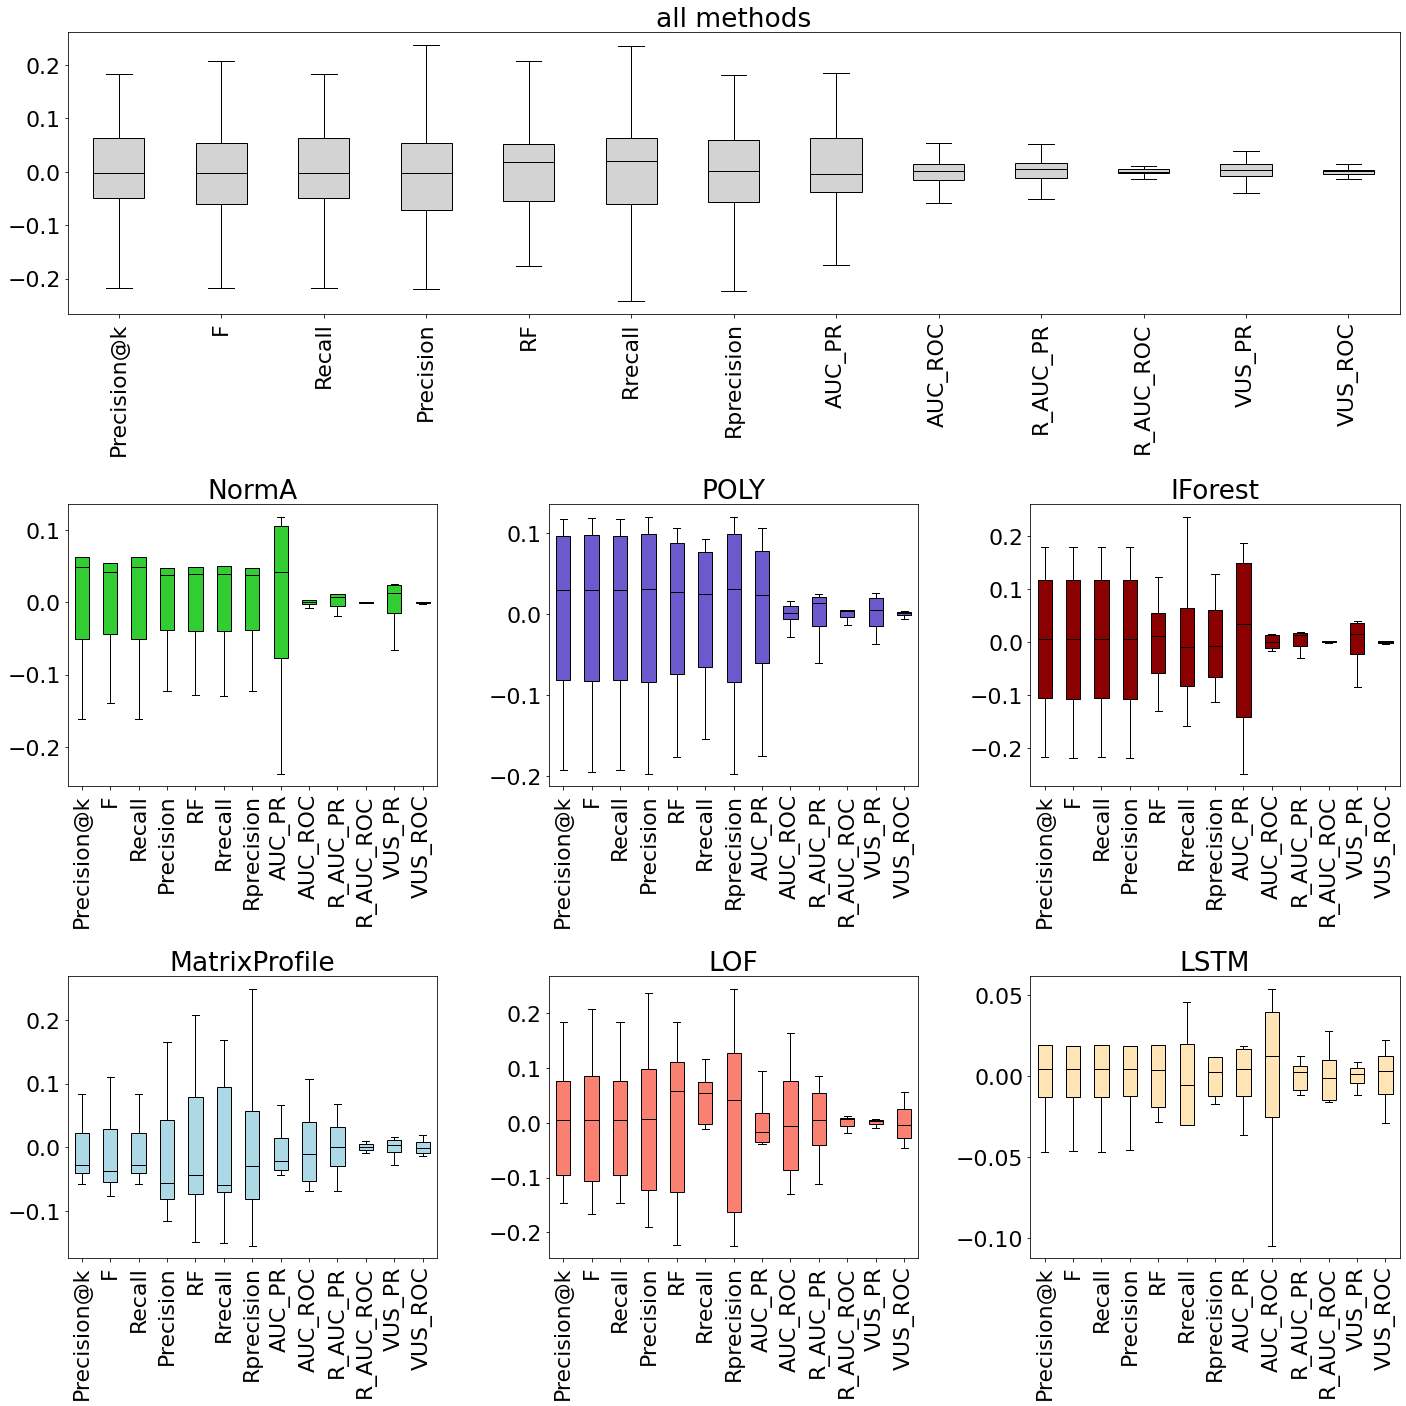

In [15]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(3, 3)

fig.add_subplot(gs[0, :])
labels, data = [*zip(*group_norm_methods_acc_lag.items())]
plt.title("all methods")
bp = plt.boxplot(data,showfliers=False,patch_artist=True)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black')
for patch in bp['boxes']:
    patch.set(facecolor="lightgrey")
plt.xticks(range(1, len(labels) + 1), labels,rotation=90)

for i,key in enumerate(norm_methods_acc_lag.keys()):
    fig.add_subplot(gs[i//3+1,i%3])    
    plt.title(key)
    labels, data = [*zip(*norm_methods_acc_lag[key].items())]
    bp = plt.boxplot(data,showfliers=False,patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black')
    for patch in bp['boxes']:
        patch.set(facecolor=colors_method[i])
    plt.xticks(range(1, len(labels) + 1), labels, rotation=90)
plt.tight_layout()
plt.savefig('results_figures/lag_robustness.pdf',format='pdf')

# Noise sensitivity on MBA(805)

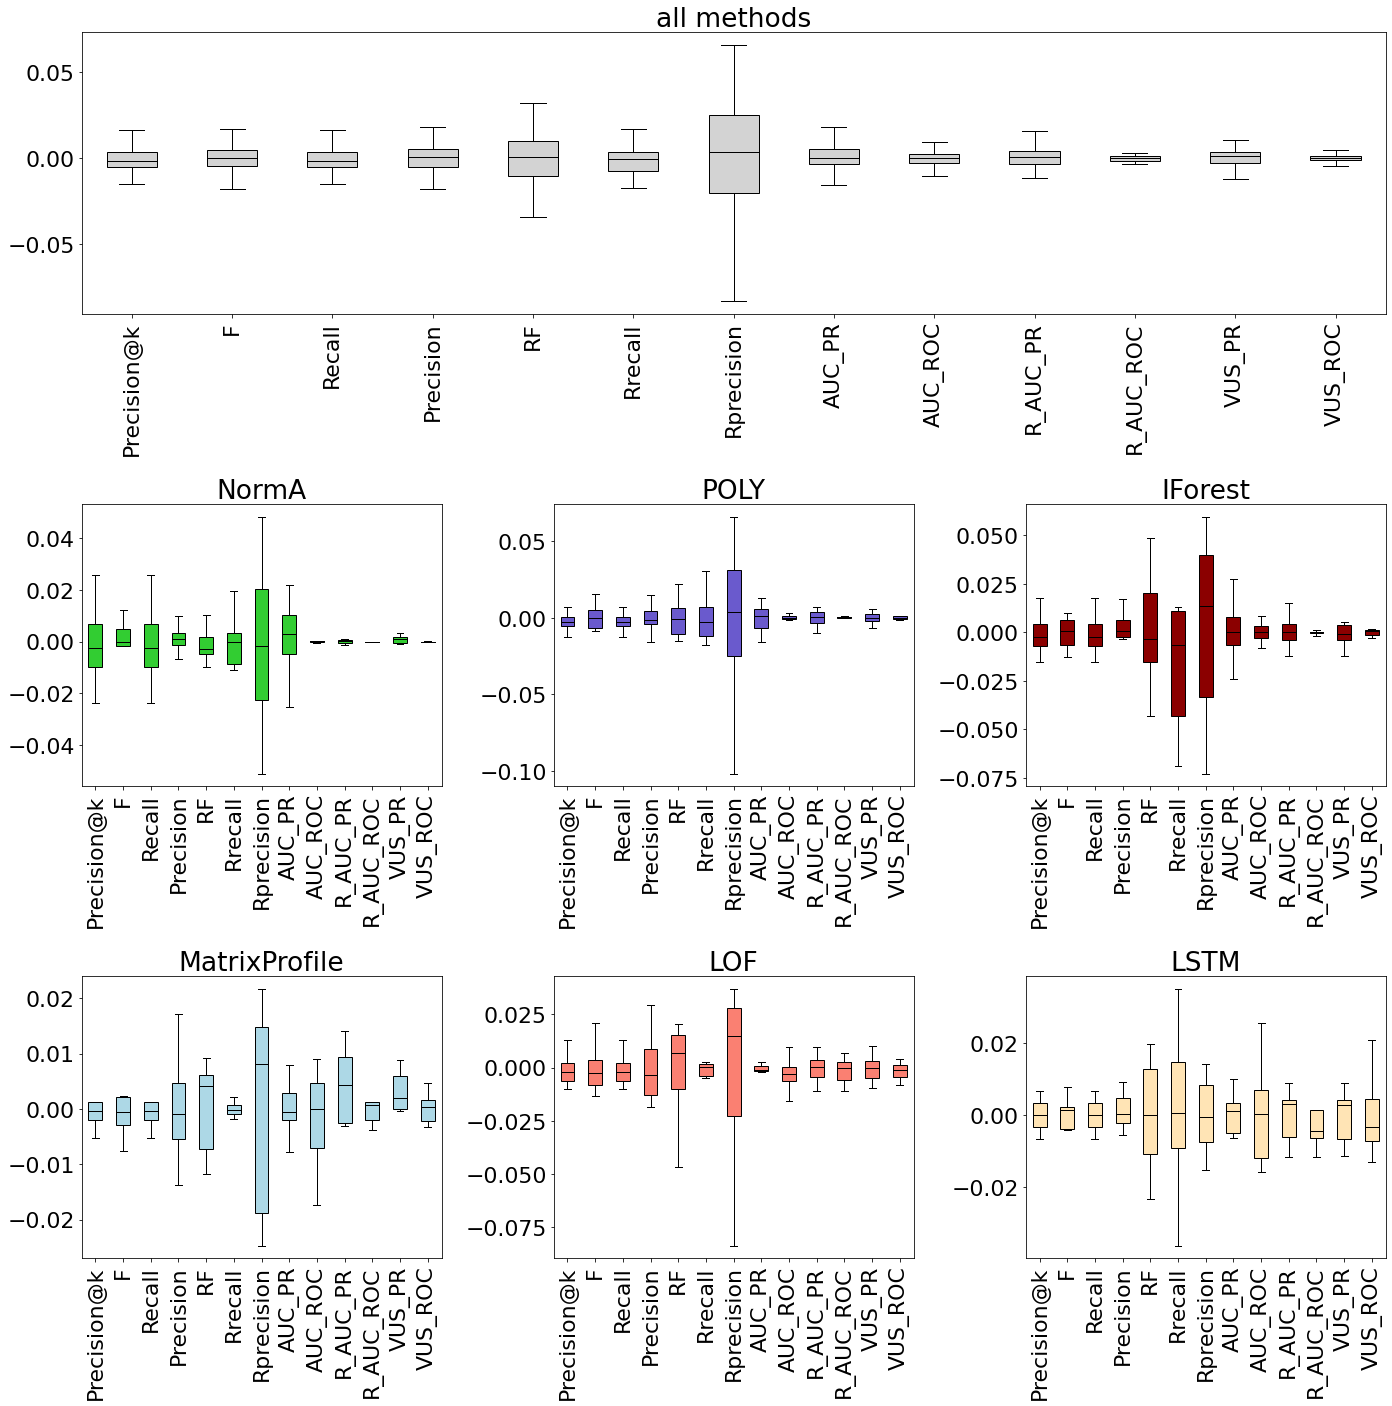

In [16]:
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(3, 3)

fig.add_subplot(gs[0, :])
labels, data = [*zip(*group_norm_methods_acc_noise.items())]
plt.title("all methods")
bp = plt.boxplot(data,showfliers=False,patch_artist=True)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black')
for patch in bp['boxes']:
    patch.set(facecolor="lightgrey")
plt.xticks(range(1, len(labels) + 1), labels,rotation=90)

for i,key in enumerate(norm_methods_acc_noise.keys()):
    fig.add_subplot(gs[i//3+1,i%3])    
    plt.title(key)
    labels, data = [*zip(*norm_methods_acc_noise[key].items())]
    bp = plt.boxplot(data,showfliers=False,patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black')
    for patch in bp['boxes']:
        patch.set(facecolor=colors_method[i])
    plt.xticks(range(1, len(labels) + 1), labels, rotation=90)
plt.tight_layout()
plt.savefig('results_figures/noise_robustness.pdf',format='pdf')


# normal/abnormal Ratio sensitivity on MBA(805)

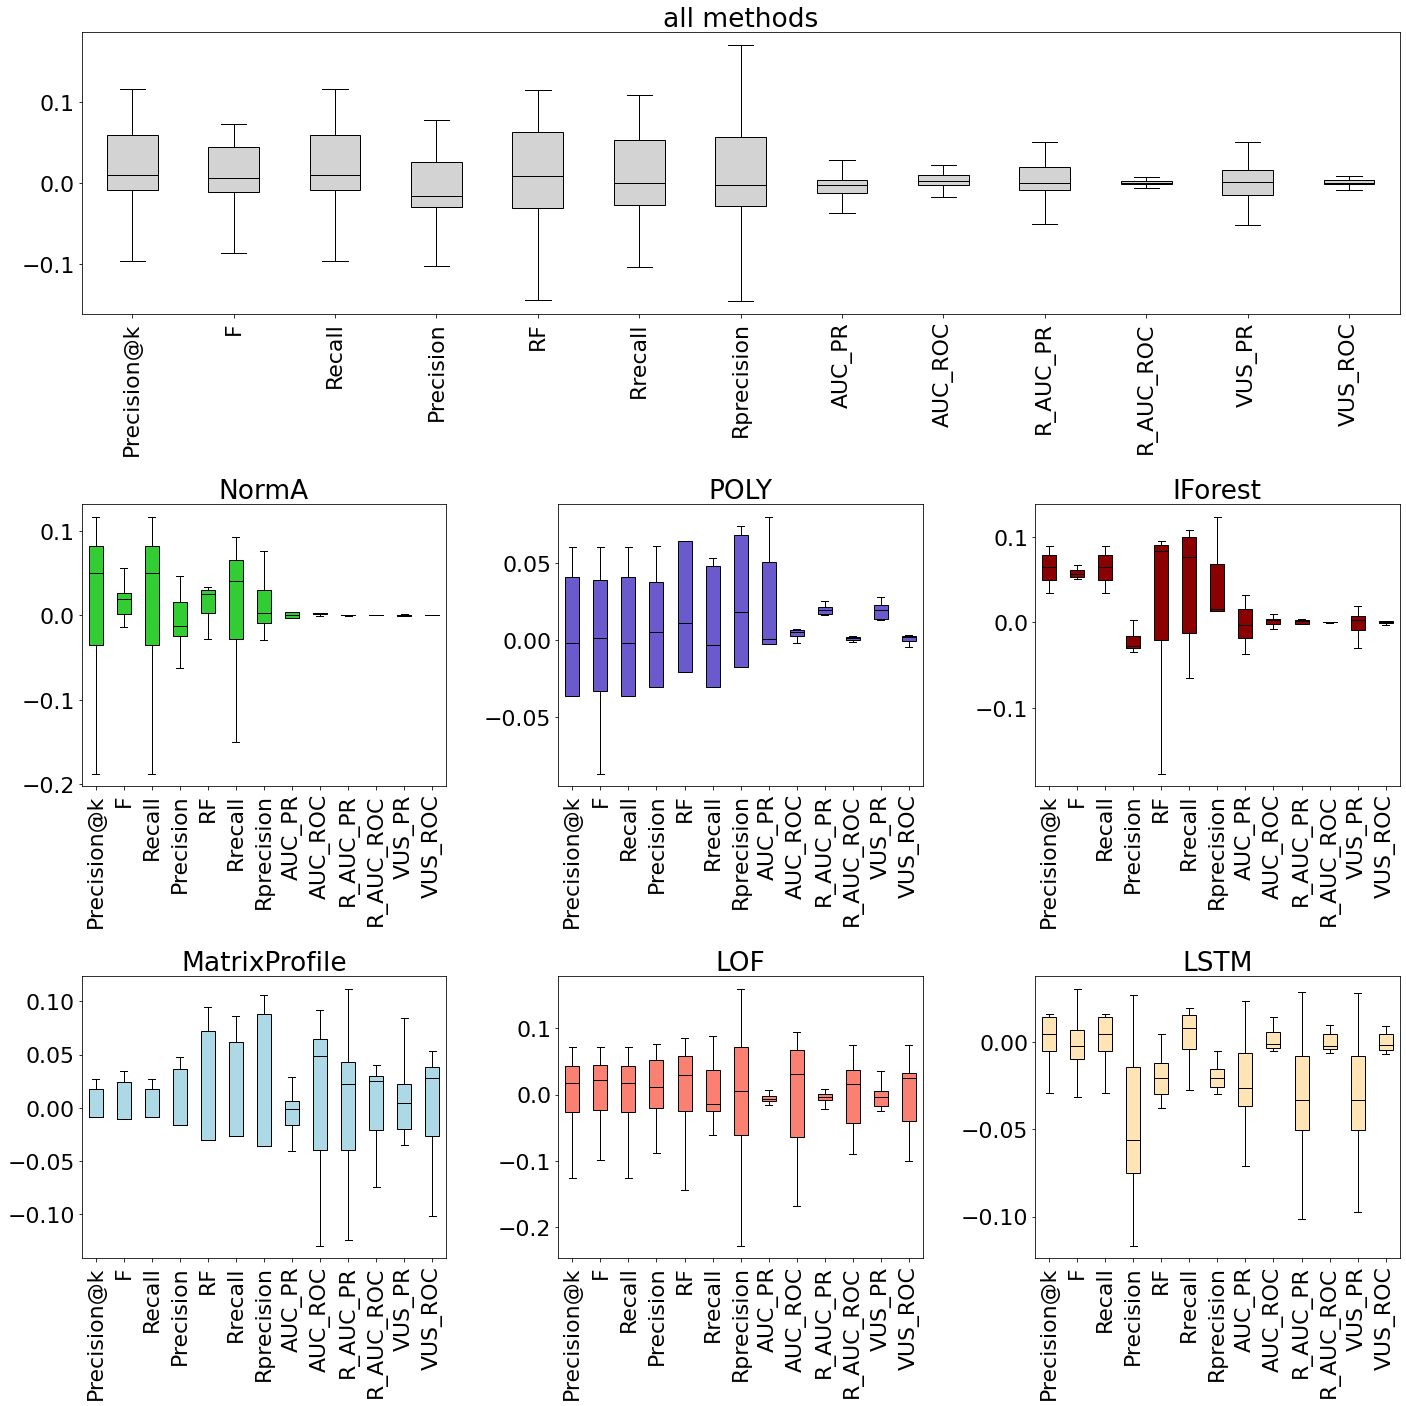

In [17]:
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(3, 3)

fig.add_subplot(gs[0, :])
labels, data = [*zip(*group_norm_methods_acc_percentage.items())]
plt.title("all methods")
bp = plt.boxplot(data,showfliers=False,patch_artist=True)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black')
for patch in bp['boxes']:
    patch.set(facecolor="lightgrey")
plt.xticks(range(1, len(labels) + 1), labels,rotation=90)

for i,key in enumerate(norm_methods_acc_percentage.keys()):
    fig.add_subplot(gs[i//3+1,i%3])    
    plt.title(key)
    labels, data = [*zip(*norm_methods_acc_percentage[key].items())]
    bp = plt.boxplot(data,showfliers=False,patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black')
    for patch in bp['boxes']:
        patch.set(facecolor=colors_method[i])
    plt.xticks(range(1, len(labels) + 1), labels, rotation=90)
plt.tight_layout()
plt.savefig('results_figures/ratio_robustness.pdf',format='pdf')
